<a href="https://colab.research.google.com/github/caltdreamer/GNN/blob/main/SyntheticData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torch-geometric
!pip install umap-learn
!pip install conditionalconformal

In [2]:
import torch
import math
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import NeighborSampler
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import NELL
from torch_geometric.datasets import CitationFull
from torch_geometric.datasets import CoraFull
from torch_geometric.data import DataLoader
from torch_geometric.nn import BatchNorm
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import os.path as osp
import pandas as pd
import numpy as np
import collections
import random
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from conditionalconformal.synthetic_data import generate_cqr_data, indicator_matrix
from conditionalconformal import CondConf

from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [21]:
#Construct Data (X,Y) 1-d case for better illustrations
#Please Use this as illustration
dimension=1
def generate_cqr_data(n_total):


    def f(x):

        ax = 0*x
        for i in range(len(x)):
            ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
            ax[i] += 10*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
        return ax.astype(np.float32)

    #x sampled from uniform[0,5] for better visualizing
    x_all = np.random.uniform(0, 5.0, size=n_total).astype(np.float32)


    y_all = f(x_all)
    return x_all,y_all
num_nodes = 1000
x_all,y_all = generate_cqr_data(num_nodes)
x_all = x_all.reshape(num_nodes,1)

In [23]:
#Generate graph using k nearest neighbors
def generate_data_graph(k=5):
    X, Y = x_all,y_all
    #X = X.reshape(-1, 1)
    knn = NearestNeighbors(n_neighbors=k+1).fit(X)
    adj_matrix = knn.kneighbors_graph(X, mode="connectivity").toarray()
    edge_index = np.argwhere(adj_matrix)
    edge_index = torch.tensor(edge_index).t().long()

    x_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(Y, dtype=torch.float32)

    data = Data(x=x_tensor, y=y_tensor, edge_index=edge_index)

    return data

In [ ]:
data = generate_data_graph(k=10)
print(data)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)

In [ ]:
#Plot our feature versus the label
x_first_dim = x[:, ].numpy()
y_numpy = y.numpy()
plt.scatter(x_first_dim[:,0], y_numpy, alpha=0.6, edgecolors="w", linewidth=0.5)
plt.xlabel("First Dimension of X")
plt.ylabel("Label (Y)")
plt.title("First Dimension of X vs. Label Y")
plt.show()

In [34]:
#Randomly choose train and calitest set
marginal_condi_shifts = []
marginal_condi_groups = []
marginal_split = []
ubs_condi_shifts = []
lbs_condi_shifts = []
ubs_condi_groups = []
lbs_condi_groups = []
ubs_split =[]
lbs_split = []
q = []

for c in range(1):
      train_percentage = 0.5
      test_percentage = 0.5



      num_nodes = data.num_nodes
      all_node_indices = list(range(num_nodes))
      random.shuffle(all_node_indices)
      num_train_nodes = int(train_percentage * num_nodes)
      num_testandcali_nodes = num_nodes - num_train_nodes
      train_node_indices = all_node_indices[:num_train_nodes]
      testandcali_node_indices = all_node_indices[num_train_nodes:]

      test_node_indices = testandcali_node_indices[:int(test_percentage * num_testandcali_nodes)]
      cali_node_indices = testandcali_node_indices[int(test_percentage * num_testandcali_nodes):]


      train_mask = torch.zeros(num_nodes, dtype=torch.bool)
      train_mask[train_node_indices] = True
      train_mask = torch.zeros(num_nodes, dtype=torch.bool)
      train_mask[train_node_indices] = True

      testandcali_mask = torch.zeros(num_nodes,dtype=torch.bool)
      testandcali_mask[testandcali_node_indices] = True

      test_mask = torch.zeros(num_nodes,dtype=torch.bool)
      test_mask[test_node_indices] = True


      cali_mask = torch.zeros(num_nodes,dtype=torch.bool)
      cali_mask[cali_node_indices] = True

      #*********************************************

      #print(train_mask)
      #print(test_mask.sum())
      #print(cali_mask.sum())
      n_train =train_mask.sum()
      n_calib = test_mask.sum()
      n_test = cali_mask.sum()


      #*********************************************
      #Use same Notation as the synthetic data
      x_train_final, y_train_final, x_calib, y_calib, x_test, y_test= x[train_mask].detach().cpu().numpy(), y[train_mask].detach().cpu().numpy(), x[cali_mask].detach().cpu().numpy(), y[cali_mask].detach().cpu().numpy(), x[test_mask].detach().cpu().numpy(), y[test_mask].detach().cpu().numpy()

      x_all = np.concatenate((x_train_final, x_calib, x_test), axis=0)
      y_all = np.concatenate((y_train_final,y_calib,y_test),axis = 0)
      #*********************************************
      train_loader = NeighborSampler(
          data.edge_index, node_idx=(train_mask),
          sizes=[3, 3, 3], batch_size=32, shuffle=False,
      )
      #*********************************************
      class SAGERegressor(torch.nn.Module):
          def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
              super(SAGERegressor, self).__init__()

              self.num_layers = num_layers
              self.convs = torch.nn.ModuleList()
              self.batch_norms = torch.nn.ModuleList()
              self.convs.append(SAGEConv(in_channels, hidden_channels))
              self.batch_norms.append(BatchNorm(hidden_channels))

              for i in range(num_layers - 2):
                  self.convs.append(SAGEConv(hidden_channels, hidden_channels))
                  self.batch_norms.append(BatchNorm(hidden_channels))

              self.convs.append(SAGEConv(hidden_channels, out_channels))
              self.batch_norms.append(BatchNorm(out_channels))
              self.linear1 = torch.nn.Linear(out_channels, hidden_channels)
              self.linear2 = torch.nn.Linear(hidden_channels, 1)

          def reset_parameters(self):

              for conv in self.convs:
                  conv.reset_parameters()
              for bn in self.batch_norms:
                  bn.reset_parameters()
              self.linear1.reset_parameters()
              self.linear2.reset_parameters()


          def forward(self, x, adjs):
              for i, (edge_index, _, size) in enumerate(adjs):
                  x_target = x[:size[1]]
                  x = self.convs[i]((x, x_target), edge_index)

                  x = self.batch_norms[i](x)
                  if i != self.num_layers - 1:
                      x = F.leaky_relu(x, 0.2)
                      x = F.dropout(x, p=0.1, training=self.training)

              x = F.leaky_relu(self.linear1(x), 0.2)
              x = self.linear2(x)

              return x
      #*********************************************
      #regression task
      model = SAGERegressor(data.num_features, 2, 1, num_layers=3)
      model.reset_parameters()
      model = model.to(device)
      #print(model)
      #*********************************************
      model.reset_parameters()
      #*********************************************
      optimizer = torch.optim.Adam(model.parameters(),lr = 0.005)
      def train(epoch):
          model.train()
          i=0
          for batch_size,n_id,adjs in train_loader:

              adjs = [adj.to(device) for adj in adjs]
              optimizer.zero_grad()
              # l1_emb, l2_emb, l3_emb = model(x[n_id], adjs)
              l3_emb = model(x[n_id], adjs)
              loss = F.mse_loss(l3_emb,y[n_id][:batch_size].unsqueeze(1))
              loss.backward()
              optimizer.step()
              i+=loss

          return i
      for epoch in range(1,30):
          loss = train(epoch)

      #*********************************************
      Calib_loader = NeighborSampler(data.edge_index,node_idx = cali_mask
        , sizes = [3,3,3],batch_size = int((test_mask+cali_mask).sum()),shuffle=False)

      Test_loader = NeighborSampler(data.edge_index,node_idx = test_mask,sizes = [3,3,3],batch_size = int((test_mask+cali_mask).sum()),shuffle=False)
      #*********************************************
      #function the takes graph loader to the third layer embedding and the fn which is
      #a matrix in the form [x,predicted y]
      def inference_1(subgraph_loader):
          model.eval()
          for batch_size,n_id,adjs in subgraph_loader:

              #emb1,emb2,emb3 = model(x[n_id],adjs)
              emb3 = model(x[n_id],adjs)

              c = x[n_id][:batch_size]
              fn = torch.cat((c, emb3), dim=1)


          return emb3,fn
      #*********************************************
      emb3_Calib,fn_Calib = inference_1(Calib_loader)
      emb3_Test,fn_Test =  inference_1(Test_loader)
      fn_Calib = fn_Calib.detach().cpu().numpy()
      fn_Test = fn_Test.detach().cpu().numpy()
      fn = np.vstack((fn_Calib,fn_Test))
      prediction_dimension = data.num_features
      #print(fn[:,prediction_dimension])

      import matplotlib.pyplot as plt

      #plt.scatter(x_test[:, 0], fn[:,prediction_dimension][-n_test:], color='green', marker='o', label='Data Points')
      #plt.scatter(x_test[:, 0], y_test, color='red', marker='o', label='Data Points')

      # Adding labels and title
     # plt.xlabel('X values in the first dimension')
     # plt.ylabel('Y values')
     # plt.title('Scatter Plot of (x,y) Points')
     # plt.legend()
     # plt.show()

      #*********************************************
      dimension = data.num_features
      #x is input vector and output is predicted label vector
      def get_xhat(x_vector):
        if(len(x_vector.shape)==2):
              xhat_1= np.ones((x_vector.shape[0], 1))
              for j in range(x_vector.shape[0]):
                for i in range((cali_mask+test_mask).sum()):
                  if(np.array_equal(x_vector[j],fn[i,0:dimension])):
                    xhat_1[j]=fn[i,dimension]
              return xhat_1
        else:
              for i in range((cali_mask+test_mask).sum()):
                if(np.array_equal(x_vector.squeeze(),fn[i,0:dimension])):
                  return fn[i,dimension]
      #*********************************************

      #Two sided confidence interval
      score_fn = lambda x, y : np.abs(y - get_xhat(x).squeeze())
      score_inv_fn = lambda s, x : [get_xhat(x)-s, get_xhat(x) + s]
      score_inv_fn_lb = lambda s, x : [get_xhat(x) + s, np.inf]
      #*********************************************
      def indicator_matrix(scalar_values, disc):
          scalar_values = np.array(scalar_values)
        # print(scalar_values.shape)
          intervals = [(disc[i], disc[i + 1]) for i in range(len(disc) - 1)]

          matrix = np.zeros((scalar_values.shape[0], len(intervals)))

          for i in range(scalar_values.shape[0]):
            value = scalar_values[i,0]
            for j,(a,b) in enumerate(intervals):
              if (a<= value <b):
                matrix[i,j] = 1

          return matrix
      #*********************************************
      #Consider covariate shift of one of the dimension
      dimension_interest = 0
      #*********************************************
      minimum = data.x[:,dimension_interest].min()
      maximum = data.x[:,dimension_interest].max()
      #disc depends on the minimum and maximum of the second dimension
      disc = np.arange(math.ceil(minimum)-1, math.ceil(maximum),1)
      def phi_fn_groups(x_12):
        if len(x_12.shape) == 2:
          a=x_12[:x_12.shape[0],dimension_interest]
          a = a.reshape(-1,1)
          return indicator_matrix(a, disc)
        else:
          a = x_12.reshape(-1,1)
          a = a[dimension_interest]
          a = a.reshape(-1,1)
          return indicator_matrix(a, disc)


      eval_locs = [1, 3]
      eval_scale = 0.2

      other_locs = [2,4]
      other_scale = 1

      def phi_fn_shifts(x_13):
          if(len(x_13.shape) == 2):
            a = x_13[:x_13.shape[0],dimension_interest]

            shifts = [norm.pdf(a, loc=loc, scale=eval_scale).reshape(-1,1)
                          for loc in eval_locs]
            shifts.extend([norm.pdf(a, loc=loc, scale=other_scale).reshape(-1,1)
                          for loc in other_locs])
            shifts.append(np.ones((a.shape[0], 1)))
            return np.concatenate(shifts, axis=1)

          else:
            a = x_13.reshape(-1,1)
            a = a[dimension_interest]
            shifts = [norm.pdf(a, loc=loc, scale=eval_scale).reshape(-1,1)
                          for loc in eval_locs]
            shifts.extend([norm.pdf(a, loc=loc, scale=other_scale).reshape(-1,1)
                          for loc in other_locs])
            shifts.append(np.ones((a.shape[0], 1)))
            return np.concatenate(shifts, axis=1)

      #*********************************************
      #Set up the problem by shifts
      infinite_params = {}
      cond_conf = CondConf(score_fn, phi_fn_shifts, infinite_params)
      cond_conf.setup_problem(x_calib, y_calib)

      n_test = len(x_test)
      alpha = 0.05
      lbs_shifts = np.zeros((n_test,))
      ubs_shifts = np.zeros((n_test,))
      i = 0
      for x_t in tqdm(x_test):
          res = cond_conf.predict(1-alpha, x_t, score_inv_fn)
          lbs_shifts[i] = res[0]
          ubs_shifts[i] = res[1]
          i += 1
      #*********************************************
      #Set up the problem by groups
      infinite_params = {}
      cond_conf = CondConf(score_fn, phi_fn_groups, infinite_params)
      cond_conf.setup_problem(x_calib, y_calib)

      n_test = len(x_test)
      alpha = 0.05
      lbs_groups = np.zeros((n_test,))
      ubs_groups = np.zeros((n_test,))
      i = 0
      for x_t in tqdm(x_test):
          res = cond_conf.predict(1-alpha, x_t, score_inv_fn)
          lbs_groups[i] = res[0]
          ubs_groups[i] = res[1]
          i += 1

       #*********************************************
      def get_marginalcoverage_condi(ubs_1,lbs_1):
        j=0
        for i in range(len(x_test)):
          if((y_test[i]<=ubs_1[i]) & (y_test[i]>=lbs_1[i])):
            j+=1

        return j/len(x_test)
      def get_marginalcoverage_split():
        j=0
        x_hat = get_xhat(x_test)
        for i in range(len(x_test)):
          if((y_test[i]>=x_hat[i]-q )& (y_test[i]<= x_hat[i]+q)):
            j+=1

        return j/len(x_test)

      q = np.quantile(np.abs(get_xhat(x_calib) - y_calib.reshape(-1,1)),
                      np.ceil((len(x_calib) + 1) * (0.95)) / len(x_calib),)
      marginal_coverage_split = get_marginalcoverage_split()
      marginal_coverage_condi_shifts = get_marginalcoverage_condi(ubs_shifts,lbs_shifts)
      marginal_coverage_condi_groups = get_marginalcoverage_condi(ubs_groups,lbs_groups)

      marginal_condi_shifts.append(marginal_coverage_condi_shifts)
      marginal_condi_groups.append(marginal_coverage_condi_groups)
      marginal_split.append(marginal_coverage_split)
      ubs_condi_shifts.append(ubs_shifts)
      lbs_condi_shifts.append(lbs_shifts)
      ubs_condi_groups.append(ubs_groups)
      lbs_condi_groups.append(lbs_groups)
      ubs_split.append(get_xhat(x_test)-q)
      lbs_split.append(get_xhat(x_test)+q)

100%|██████████| 250/250 [02:25<00:00,  1.72it/s]


In [35]:
lbs_shifts = lbs_condi_shifts[0]
ubs_shifts = ubs_condi_shifts[0]
#print(ubs_shifts-lbs_shifts)
print(marginal_split)
print(marginal_condi_shifts)

[0.936]
[0.952]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [193]:
# Example list of ndarrays
def serialize_ndarrays(list_of_ndarrays):
    return '\n\n'.join('\n'.join(' '.join(str(cell) for cell in row) for row in arr) if arr.ndim > 1 else ' '.join(str(cell) for cell in arr) for arr in list_of_arrays)
ubs_condi_shifts_string = serialize_ndarrays(ubs_condi_shifts)
lbs_condi_shifts_string = serialize_ndarrays(lbs_condi_shifts)
ubs_condi_groups_string = serialize_ndarrays(ubs_condi_groups)
lbs_condi_groups_string = serialize_ndarrays(lbs_condi_groups)
marginal_condi_shifts_string = serialize_ndarrays(marginal_condi_shifts)
marginal_condi_groups_string = serialize_ndarrays(marginal_condi_groups)
marginal_split_string = serialize_ndarrays(marginal_split)
ubs_split_string =  serialize_ndarrays(ubs_split)
lbs_split_string = serialize_ndarrays(lbs_split)
# Path to your Googleserialize_ndarrayserialize_ndarrays(ubs_split)s(ubs_condi_shifts) Drive
file_path = '/content/drive/My Drive/synthetic data_10runs.txt'
with open(file_path, 'w') as f:
    f.write(ubs_condi_shifts_string)
    f.write(lbs_condi_shifts_string)
    f.write(ubs_condi_groups_string)
    f.write(lbs_condi_groups_string)
    f.write(marginal_condi_shifts_string)
    f.write(marginal_condi_groups_string)
    f.write(marginal_split_string)
    f.write(ubs_split_string)
    f.write(lbs_split_string )



In [30]:
#Take first result as example
lbs = lbs_condi_shifts[0]
ubs = ubs_condi_shifts[0]

IndexError: ignored

Text(0.5, 1.0, 'Conditional Calibration')

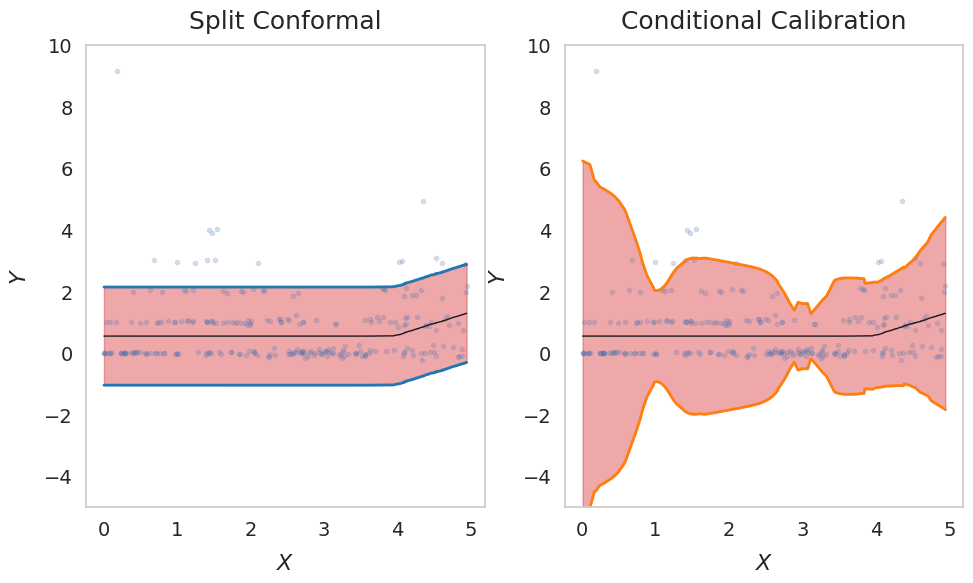

In [36]:
q = np.quantile(np.abs(get_xhat(x_calib) - y_calib.reshape(-1,1)),
                np.ceil((len(x_calib) + 1) * (0.95)) / len(x_calib),)
cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(17.5, 6)
sort_order = np.argsort(x_test[0:n_test,dimension_interest])
x_test_s = x_test[0:n_test,dimension_interest][sort_order]
y_test_s = y_test[sort_order]
y_test_hat = get_xhat(x_test[sort_order])
lb = lbs_shifts[sort_order]
ub = ubs_shifts[sort_order]

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, y_test_hat + q, color=cp[0], lw=2)
ax1.plot(x_test_s, y_test_hat - q, color=cp[0], lw=2)

ax1.set_ylim(-5,10)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)
ax1.fill_between(x_test_s.flatten(), y_test_hat.flatten() - q, y_test_hat.flatten() + q,
                 color=cp[3], alpha=0.4, label='split prediction interval')


ax2 = fig.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, y_test_hat, color='k', lw=1)
ax2.plot(x_test_s, ub, color=cp[1], lw=2)
ax2.plot(x_test_s, lb, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), lb,
                 ub,
                 color=cp[3], alpha=0.4, label='conditional calibration')
ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)